# Testing Video Game Recommender Systems

In [1]:
# set-up
import pandas as pd

# web-scraping
import urllib
import requests
import re
from bs4 import BeautifulSoup

# surprise
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVDpp, SVD, accuracy
from collections import defaultdict

# sklearn
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import normalize, MaxAbsScaler, Normalizer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import seaborn as sns

## Import and Preprocess Dataset

The dataset used for this recommender system is the [Steam Video Games Data](https://www.kaggle.com/tamber/steam-video-games) from Kaggle. This dataset contains the following columns: user-id, game-title, behavior-name, value. 
The `behavior-name` column corresponds to whether each user played or purchased each game. The `value` column indicates the amount of hours that the user played the game, with the default value being 1.0.

In [2]:
user_url = "https://raw.githubusercontent.com/mkivenson/" + \
"Recommender-Systems/master/Video%20Game%20Recommendations/steam-200k.csv"
user_df = pd.read_csv(user_url, 
                      header = None,
                      usecols = list(range(4)),
                      names = ['user_id','game_title','action','hours_played'])
user_df.head()

,user_id,game_title,action,hours_played
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


### Clean-Up Dataset

In [3]:
user_df = (pd.pivot_table(user_df, 
                      index = ['user_id','game_title'], 
                      columns='action', 
                      values='hours_played')
        .reset_index()
        .fillna(0)
        .rename(index = str, columns = {'play': 'hours_played', 'purchase':'purchased'}))
user_df.head(n=10)

action,user_id,game_title,hours_played,purchased
0,5250,Alien Swarm,4.9,1.0
1,5250,Cities Skylines,144.0,1.0
2,5250,Counter-Strike,0.0,1.0
3,5250,Counter-Strike Source,0.0,1.0
4,5250,Day of Defeat,0.0,1.0
5,5250,Deathmatch Classic,0.0,1.0
6,5250,Deus Ex Human Revolution,62.0,1.0
7,5250,Dota 2,0.2,1.0
8,5250,Half-Life,0.0,1.0
9,5250,Half-Life 2,0.0,1.0


### Create Compressed Sparse Row (CSR) Matrix

In [4]:
matrix = (user_df.pivot(index = 'game_title', columns = 'user_id', values = 'purchased')
                    .fillna(int(0)))
csr_games = csr_matrix(matrix)

# Item-Item Recommender Systems
## Principal Component Analysis (PCA)

PCA is a feature decorrelation and dimension reduction technique. To implement PCA, the first step is to determine the instrinsic dimension of the features (users).

### Determine Intrinsic Dimension

The intrinsic dimension of a dataset is the amount of features needed to approximate the sample. Using the correct intrinsic dimension of a dataset when performing PCA allows for the most compact representation of a sample. 

In [5]:
#Intrinsic Dimension
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(matrix)
features = range(pca.n_components_)

#### Plot Variance of Features

The following plot shows the `explained_variance_` of the top 30 features in the dataset. The amount of intrinsic dimensions can be determined by selecting an amount of features that provide the highest variance. In other words, we select `n` features, where `n` begins to show a drop-off in variance change. From the plot below, using anywhere between 2 and 6 components will be ideal. For this situation, 6 components will be used in hopes of maximizing accuracy. 

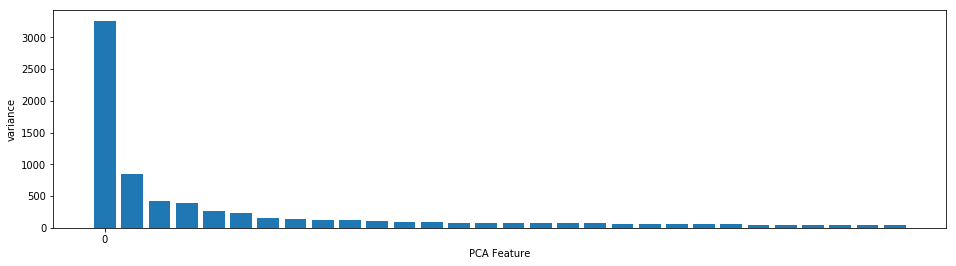

In [6]:
figure(figsize=(16,4))
plt.bar(features[0:30], pca.explained_variance_[0:30])
plt.xlabel('PCA Feature')
plt.ylabel('variance')
plt.xticks(features)
plt.locator_params(axis='x', nbins=10)
plt.show()

### Implement Algorithm

To implement PCA, a pipeline is used to first scale features, then fit and transform the matrix using PCA. The result is a combination of six values for each movie. These six principal components are added together to represent each movie.

In [7]:
scaler = StandardScaler()
pca = PCA(n_components = 6)
pipeline = make_pipeline(scaler, pca)
pipeline.fit(matrix)
transformed = pipeline.transform(matrix)
pca_df = pd.DataFrame(transformed, index = matrix.index.values)
pca_df.head()

,0,1,2,3,4,5
007 Legends,-1.235490,-1.420457,-2.035538,1.137223,-0.054784,-1.063800
0RBITALIS,-1.145023,-1.398605,-1.950518,1.053306,0.006929,-0.989795
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),-1.208227,-1.323516,-1.903177,0.943608,0.017872,-0.978161
10 Second Ninja,-1.216546,-1.325302,-1.832160,0.886723,0.059678,-0.962648
"10,000,000",-1.233914,-1.420588,-2.041735,1.134170,-0.063804,-1.102892


### Get PCA Recommendation
To return recommendations for each video game, the `get_recommendations` function is created. It accepts inputs of a `features` table that results from a transformed matrix. The index is the name of each item - in this case, it is a list of video games. Finally, the `game` input specifies which video game to provide recommendations for.

The function normalizes feature values and then applies cosine similarity to return recommended video games.

In [8]:
def get_recommendations(features, index, game):

    #cosine similarity
    norm_features = normalize(features)
    df = pd.DataFrame(norm_features, index = index)
    current_item = df.loc[game]
    similarities = df.dot(current_item)
    print(similarities.nlargest(n=6))

#### The Elder Scrolls V Skyrim

In [9]:
get_recommendations(transformed, matrix.index.values, "The Elder Scrolls V Skyrim")

The Elder Scrolls V Skyrim                 1.000000
Grand Theft Auto San Andreas               0.998927
Left 4 Dead 2                              0.996719
Skyrim High Resolution Texture Pack        0.995842
The Elder Scrolls V Skyrim - Hearthfire    0.995714
The Elder Scrolls V Skyrim - Dawnguard     0.995105
dtype: float64


#### Dragon Age Origins

In [10]:
get_recommendations(transformed, matrix.index.values, "Dragon Age Origins")

Dragon Age Origins                   1.000000
Assassin's Creed                     0.991602
The Elder Scrolls III Morrowind      0.990266
Magicka Nippon                       0.990163
Magicka Final Frontier               0.987833
Supreme Commander Forged Alliance    0.982603
dtype: float64


#### Half-Life 2

In [11]:
get_recommendations(transformed, matrix.index.values, "Half-Life 2")

Half-Life 2                    1.000000
Half-Life Deathmatch Source    0.998176
Day of Defeat Source           0.997832
Half-Life 2 Lost Coast         0.996320
Half-Life 2 Episode One        0.995544
Half-Life 2 Deathmatch         0.995426
dtype: float64


## Truncated SVD

We can use the `get_recommendation` function for other algorithms as well. Like PCA, Truncated SVD can be used for dimension reduction. The advantage of the SVD function is that it can accept a compressed sparse row (CSR) matrix. A CSR matrix is ideal for sparse arrays, since only non-null values are stored. This improves performance and saves space. 

In [12]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components = 6)
model.fit(csr_games)
transformed = model.transform(csr_games)

#### The Elder Scrolls V Skyrim

In [13]:
get_recommendations(transformed, matrix.index.values, "The Elder Scrolls V Skyrim")

The Elder Scrolls V Skyrim                 1.000000
NBA 2K15                                   0.994264
Fallout 4                                  0.993566
The Elder Scrolls V Skyrim - Hearthfire    0.992460
The Elder Scrolls V Skyrim - Dawnguard     0.992077
DARK SOULS II                              0.991237
dtype: float64


#### Dragon Age Origins

In [14]:
get_recommendations(transformed, matrix.index.values, "Dragon Age Origins")

Dragon Age Origins    1.000000
McPixel               0.997017
Sanctum               0.996147
The Darkness II       0.995065
METAL SLUG 3          0.995042
F1 2013               0.994967
dtype: float64


#### Half-Life 2

In [15]:
get_recommendations(transformed, matrix.index.values, "Half-Life 2")

Half-Life 2                         1.000000
Half-Life 2 Episode One             0.994299
Half-Life Deathmatch Source         0.990490
Blazing Angels Squadrons of WWII    0.989305
Half-Life 2 Lost Coast              0.988143
Half-Life 2 Episode Two             0.987866
dtype: float64


## Non-Negative Matrix Factorization

In [16]:
scaler = MaxAbsScaler()
nmf = NMF(n_components = 6)
pipeline = make_pipeline(scaler, nmf)
pipeline.fit(csr_games)
transformed = pipeline.transform(csr_games)

In [17]:
get_recommendations(transformed, matrix.index.values, "The Elder Scrolls V Skyrim")

The Elder Scrolls V Skyrim                                  1.000000
Mars Colony Challenger                                      0.999876
X Rebirth The Teladi Outpost                                0.999876
Nightmares from the Deep 3 Davy Jones                       0.999868
Far Cry 4                                                   0.999837
Mount & Blade Warband - Viking Conquest Reforged Edition    0.999711
dtype: float64


In [18]:
get_recommendations(transformed, matrix.index.values, "Dragon Age Origins")

Dragon Age Origins                          1.000000
NBA 2K13                                    0.998630
Age of Wonders Shadow Magic                 0.997375
Sid Meier's Civilization IV Colonization    0.997328
F.E.A.R.                                    0.997310
F.E.A.R. Extraction Point                   0.997310
dtype: float64


In [19]:
get_recommendations(transformed, matrix.index.values, "Half-Life 2")

Half-Life 2                         1.000000
Blazing Angels Squadrons of WWII    0.999366
Sniper Elite Zombie Army            0.996864
Half-Life Deathmatch Source         0.996675
The Club                            0.996467
BookWorm Adventures Volume 2        0.996041
dtype: float64


### Experimenting with Different Component Sizes
The following code chunk experiments with different component sizes for the NMF predictions. 

In [20]:
for i in [2,3,4,5,6,7,8,9,10]:
    scaler = MaxAbsScaler()
    nmf = NMF(n_components = i)
    pipeline = make_pipeline(scaler, nmf)
    pipeline.fit(csr_games)
    transformed = pipeline.transform(csr_games)
    print("Skyrim Recs, Amount of Components: ", i)
    get_recommendations(transformed, matrix.index.values, "The Elder Scrolls V Skyrim")
    print("")

Skyrim Recs, Amount of Components:  2
The Elder Scrolls V Skyrim          1.000000
The Ship                            1.000000
The Ship Tutorial                   1.000000
QuestRun                            1.000000
Blade Symphony                      1.000000
Left in the Dark No One on Board    0.999999
dtype: float64

Skyrim Recs, Amount of Components:  3
The Elder Scrolls V Skyrim                        1.000000
F1 2015                                           0.999964
Planetary Annihilation - Digital Deluxe Bundle    0.999773
Planetary Annihilation - Original Soundtrack      0.999773
Silent Hunter 5 Battle of the Atlantic            0.999628
Borderlands 2                                     0.999512
dtype: float64

Skyrim Recs, Amount of Components:  4
The Elder Scrolls V Skyrim    1.000000
Gunship!                      0.999371
Mount & Blade Warband         0.999337
Deadpool                      0.999317
PAYDAY Wolf Pack              0.999092
Gun Metal                     0.999

### Define Top N Recommendations Functions from Surprise

In [21]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# User-User Recommender System
## Apply SVD++ for Implicit Data

In the next step, SVD++ is used from the Surprise Python library. The video game dataset contains unary data indicating whether a user has purchased a game or not. SVD++ will be used because it is ideal for implicit data. The SVDpp algorith can return the top n predictions for each user in the dataset. 

In [22]:
reader = Reader()
user_result = Dataset.load_from_df(user_df[['user_id',
                                            'game_title', 
                                            'purchased']],
                                   reader)
train, test = train_test_split(user_result, 
                               test_size=0.25)
algo_SVDpp = SVDpp()
algo_SVDpp.fit(train)
predictions = algo_SVDpp.test(test)
get_top_n(predictions, n=3)

defaultdict(list,
            {76420334: [("Q.U.B.E Director's Cut", 1.0316937266632147),
              ('Space Engineers', 1.0279264474133043),
              ('Fallout 3 - Game of the Year Edition', 1.0256179230982054)],
             64787956: [('Hero Siege', 1.0228619766206557),
              ('Skyborn', 1.0211561130945481),
              ("Oddworld Stranger's Wrath HD", 1.0194210739727876)],
             157341587: [('RaiderZ', 1.0235346853433949),
              ('Star Conflict', 1.018087476391851),
              ('ORION Prelude', 1.01806655482393)],
             189123038: [('Nosgoth', 1.033787527072373),
              ('Team Fortress 2', 1),
              ('The Elder Scrolls V Skyrim', 1)],
             142004534: [('Dota 2', 1)],
             122189133: [('Team Fortress 2', 1)],
             81743539: [('Day of Defeat', 1.0140603719652646),
              ('Half-Life 2 Episode Two', 1.0125868669807816),
              ('Counter-Strike Condition Zero', 1.0088513744908636)],
        

### SVD++ Evaluation
The SVD++ algorithm has a great RMSE value and is seemingly highly accurate. However, because this dataset contains user-item combinations for which the user has purchased the item, the predicted value for all user-item combination in the test set is >= 1. In future applications, I would like to apply SVD++ to a sparse user-item matrix for more insightful predictions.

In [23]:
accuracy.rmse(predictions)

RMSE: 0.0163


0.01633600425596381

In [25]:
pd.DataFrame(predictions).head(n=10)

,uid,iid,r_ui,est,details
0,76420334,Age of Empires II HD Edition,1.0,1.000000,{'was_impossible': False}
1,64787956,Wolfenstein 3D,1.0,1.000000,{'was_impossible': False}
2,157341587,Dota 2,1.0,1.001336,{'was_impossible': False}
3,189123038,Nosgoth,1.0,1.033788,{'was_impossible': False}
4,142004534,Dota 2,1.0,1.000000,{'was_impossible': False}
5,122189133,Team Fortress 2,1.0,1.000000,{'was_impossible': False}
6,81743539,Half-Life 2 Episode Two,1.0,1.012587,{'was_impossible': False}
7,187463594,Dungeon Defenders II,1.0,1.000000,{'was_impossible': False}
8,172470005,Fallout 3,1.0,1.022961,{'was_impossible': False}
9,214390937,Penumbra Necrologue,1.0,1.000000,{'was_impossible': False}


# Content-Based Recommender System
### Reduce Sparsity of Dataset
To create a content-based recommender system, video game genres, descriptions, and other product information will be scraped from Metacritic. First, the size of the dataframe will be reduced to avoid memory and time contraints. 

In [40]:
print("Initial length of dataframe:", len(user_df))
user_df_dense = user_df.groupby('game_title').filter(lambda x: len(x) > 150)
print("New length of dataframe:", len(user_df_dense))

Initial length of dataframe: 128804
New length of dataframe: 57464


In [31]:
def get_game_details(game):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 

    #make game title into url-friendly format
    game_url = re.sub('\s+','-',game).lower()
    
    #web-scraping request
    URL = "https://www.metacritic.com/game/pc/" + game_url + "/details"
    request = urllib.request.Request(URL, None, headers)
    page = urllib.request.urlopen(request)
    soup = BeautifulSoup(page)
    summary = soup.select("div.summary_detail.product_summary .data")[0].text

    #get publisher
    publisher = re.sub('\n| ','',soup.select("li.summary_detail.publisher .data a")[0].text).lower()

    #get index of details
    details = [x.text for x in soup.select("#main > div.product_details th")]
    for idx, x in enumerate(details):
        if x  == 'Genre(s):':
            genre_position = idx
        if x  == 'Developer:':
            dev_position = idx

    #get genre
    genre = " ".join(re.findall('\w+-?\w+', 
                                soup.select("#main > div.product_details td")[genre_position].text)).lower()
    #get developer
    developer = " ".join(re.findall('\w+-?\w+', 
                                    soup.select("#main > div.product_details td")[dev_position].text)).lower()

    #get user score
    user_score = float(soup.select('.userscore_wrap.feature_userscore .metascore_w')[0].text)

    #get amount of ratings
    no_ratings = int(re.findall('\d+', soup.select('.userscore_wrap.feature_userscore .count a')[0].text)[0])
    return (game, summary, publisher, developer, genre, user_score, no_ratings)

In [42]:
games_df = pd.DataFrame(columns = ['game_title','summary','publisher','developer','genre', 'user_score','no_ratings'])
failures = []

for game in user_df_dense['game_title'].unique():
    try:
        game_info = get_game_details(game)
        games_df = games_df.append(pd.DataFrame([game_info],
                                                columns = games_df.columns))
    except Exception as error:
        failures.append((game, error))

game failed: arma-2
game failed: arma-2-operation-arrowhead
game failed: arma-2-operation-arrowhead-beta-(obsolete)
game failed: call-of-duty-black-ops---multiplayer
game failed: call-of-duty-modern-warfare-2---multiplayer
game failed: call-of-duty-modern-warfare-3---multiplayer
game failed: thief
game failed: thief---ghost
game failed: thief---opportunist
game failed: thief---predator
game failed: thief---the-bank-heist
game failed: thief-2
game failed: thief-deadly-shadows
game failed: thief-gold
game failed: age-of-empires-ii-hd-the-forgotten
game failed: alan-wake
game failed: alan-wake's-american-nightmare
game failed: arma-2
game failed: arma-2-operation-arrowhead
game failed: arma-2-operation-arrowhead-beta-(obsolete)
game failed: back-to-the-future-ep-1---it's-about-time
game failed: back-to-the-future-ep-2---get-tannen!
game failed: back-to-the-future-ep-3---citizen-brown
game failed: back-to-the-future-ep-4---double-visions
game failed: back-to-the-future-ep-5---outatime
game failed: deus-ex-game-of-the-year-edition
game failed: dirt-3-complete-edition
game failed: hector-ep-1
game failed: hector-ep-2
game failed: hector-ep-3
game failed: killer-is-dead
game failed: l.a.-noire
game failed: sam-&-max-301-the-penal-zone
game failed: sam-&-max-302-the-tomb-of-sammun-mak
game failed: sam-&-max-303-they-stole-max's-brain!
game failed: sam-&-max-304-beyond-the-alley-of-the-dolls
game failed: sam-&-max-305-the-city-that-dares-not-sleep
game failed: serious-sam-2
game failed: serious-sam-classic-the-first-encounter
game failed: serious-sam-classic-the-second-encounter
game failed: serious-sam-classics-revolution
game failed: serious-sam-double-d-xxl
game failed: skyrim-high-resolution-texture-pack

In [43]:
games_df

,game_title,summary,publisher,developer,genre,user_score,no_ratings
0,Alien Swarm,"Available free of charge, the game thrusts pla...",valvesoftware,valve software,action shooter shooter third-person tactical m...,8.2,428
0,Counter-Strike,Counter-Strike modifies the multiplayer aspect...,sierraentertainment,the counter-strike team,action shooter shooter first-person modern tac...,9.2,6870
0,Counter-Strike Source,Valve has taken a large selection of the maps ...,valvesoftware,valve software,action shooter shooter first-person tactical m...,8.9,10003
0,Day of Defeat,Day of Defeat is the latest online action expe...,activision,valve software,action shooter shooter first-person historic t...,9.1,792
0,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,valvesoftware,valve software,action general general shooter first-person ta...,6.7,15
0,Deus Ex Human Revolution,In Deus Ex: Human Revolution you play Adam Jen...,eidosinteractive,nixxes software,action action adventure shooter sci-fi sci-fi ...,8.5,3362
0,Dota 2,Dota 2 features the characters and factions fr...,valvesoftware,valve software,general fantasy moba strategy real-time moba,6.5,11144
0,Half-Life,Half-Life combines great storytelling in the t...,sierraentertainment,valve software,action shooter shooter first-person sci-fi sci...,9.0,3714
0,Half-Life 2,[Metacritic's 2004 PC Game of the Year] By ta...,vugames,valve software,action shooter shooter first-person sci-fi sci...,9.1,9718
0,Half-Life 2 Deathmatch,Fast multiplayer action set in the Half-Life 2...,valvesoftware,valve software,action shooter shooter first-person sci-fi sci...,7.2,66


## TF-IDF & NMF
Using the information scraped from Metacritic, tf-idf will be used in conjunction with NMF at a later time. 

# Conclusion
This project has explored various algorithms for dimensionality reduction, such as PCA, SVD, NMF, and SVD++. Different amounts of components were used for calculations depending on intrinsic dimension and recommendation success. Next steps include applying SVD++ to a sparse matrix, completing the content-based recommender system, and finding more objective methods of evaluating success of algorithms. 